# Cluster and summarize long-form audio using STT and GenAI

## Solution Overview

<p align="center">
  <img alt="Conceptual Flow" src="Screenshot 2023-08-24 at 12.33.59 PM.png" width="100%">
</p>

## Setup

### Installs

In [125]:
# Install Vertex AI LLM SDK, langchain and dependencies
!pip install google-cloud-aiplatform vertexai langchain chromadb pydantic typing-inspect typing_extensions pandas datasets google-api-python-client pypdf faiss-cpu transformers config --upgrade

  Obtaining dependency information for google-cloud-aiplatform from https://files.pythonhosted.org/packages/0b/7c/fcbb346dbfe4de0b4cccf33ed114b94921a970f7624a8b42c1aa54b7699d/google_cloud_aiplatform-1.31.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for langchain from https://files.pythonhosted.org/packages/1d/63/1e7c55a653c93cc83b642a7cf5893a9caa4a1325c2b33bc7796bd7a0f143/langchain-0.0.276-py3-none-any.whl.metadata
  Obtaining dependency information for chromadb from https://files.pythonhosted.org/packages/f2/30/0d767083adb204422e10a5529f57a8afa9dc921f76620f11693e67b23c3a/chromadb-0.4.8-py3-none-any.whl.metadata
  Obtaining dependency information for pydantic from https://files.pythonhosted.org/packages/82/06/fafdc75e48b248eff364b4249af4bcc6952225e8f20e8205820afc66e88e/pydantic-2.3.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.8/148.8 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for typing-inspect from https://

In [2]:
# # Automatically restart kernel after installs so that your environment can access the new packages
#import IPython

#app = IPython.Application.instance()
#app.kernel.do_shutdown(True)

### Imports

In [1]:
from datetime import datetime
import time
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import networkx as nx
from networkx.algorithms import community

from langchain.llms import VertexAI
from langchain.embeddings import VertexAIEmbeddings
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain

import vertexai
from vertexai.language_models import TextGenerationModel, TextEmbeddingModel
from google.cloud import aiplatform
from google.cloud import storage
from google.cloud import bigquery

### Env variables and Setup

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'mg-ce-demos'

In [3]:
REGION = 'us-central1'
LOCATION = 'us'
GCS_BUCKET = PROJECT_ID

In [4]:
DATASET = 'stt_genai'
TRANSCRIPT_TABLE = 'transcript_cumulus_demo'
TRANSCRIPT_TABLE_CHIRP = 'transcript_cumulus_demo_chirp'
SUMMARY_TABLE = 'summary_cumulus_demo'

In [5]:
# gcs client
gcs = storage.Client(project = PROJECT_ID)

# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

## Data: Get data from GCS

Can loop through GCS to pick up multiple files.  This iteration is built for one file at a time but easy to update.

Loop through GCS bucket(s) for audio files to transcribe

In [6]:
def get_audio_data(GCS_BUCKET):
    bucket = gcs.bucket(GCS_BUCKET)

    # Get the list of blobs
    blobs = bucket.list_blobs()

    # Loop through the blobs
    audio_data = []
    for blob in blobs:
        if blob.name.startswith('audio_data/cumulus'):
            if blob.name.endswith('.mp3'):
                #print(blob.name)
                audio_data.append([blob.name, blob.content_type, f'gs://{GCS_BUCKET}/{blob.name}'])
                
    return {
        'data_name': audio_data[-1][0],
        'data_type': audio_data[-1][1],
        'data_uri': audio_data[-1][2]
    }

In [7]:
sample_uri = get_audio_data(GCS_BUCKET)['data_uri']
print(sample_uri)

gs://mg-ce-demos/audio_data/cumulus/KTCKFMAirMonitor-23-2023-08-04_07-00-01-288.mp3


## Data: Transcribe audio and stringify

Until we can associate specific comments with specific people (e.g. using something like Speaker ID), speaker diarization doesn't add much value.  In v2, this was removed so we could test with the new Chirp model which did appear to improve accuracy of the transcription.

Function to transcribe audio, including speaker diarization and other features

### v2 - STT Chirp (GenAI)

In [8]:
from google.api_core.client_options import ClientOptions
from google.cloud.speech_v2 import SpeechClient as SpeechClient_v2
from google.cloud.speech_v2.types import cloud_speech as cloud_speech_v2


In [9]:
def transcribe_gcs_v2(gcs_uri: str) -> str:
    TIMEOUT_DEFAULT = 3600

    # Instantiates a client
    client = SpeechClient_v2(
        client_options=ClientOptions(
            api_endpoint="us-central1-speech.googleapis.com",
        )
    )
    
    config = cloud_speech_v2.RecognitionConfig(
        auto_decoding_config=cloud_speech_v2.AutoDetectDecodingConfig(),
        language_codes=["en-US"],
        model="chirp",
    )
    
    file_metadata = cloud_speech_v2.BatchRecognizeFileMetadata(uri=gcs_uri)

    request = cloud_speech_v2.BatchRecognizeRequest(
        recognizer=f"projects/{PROJECT_ID}/locations/{REGION}/recognizers/chirp-recognizer",
        config=config,
        files=[file_metadata],
        recognition_output_config=cloud_speech_v2.RecognitionOutputConfig(
            inline_response_config=cloud_speech_v2.InlineOutputConfig(),
        ),
    )

    # Transcribes the audio into text
    operation = client.batch_recognize(request=request)

    print("Waiting for operation to complete...")
    try:
        response = operation.result(timeout=TIMEOUT_DEFAULT)       # The default is 3600 seconds, 1 hour

    except:
        response = operation.result(timeout=1.5 * TIMEOUT_DEFAULT) # 5400 seconds, 1 hour and 30 minutes

    finally:
        response = operation.result(timeout=2 * TIMEOUT_DEFAULT)   # 7200 seconds, 2 hours

    return response


In [10]:
## BQ table check
from google.cloud.exceptions import NotFound

table_id = f"{PROJECT_ID}.{DATASET}.{TRANSCRIPT_TABLE_CHIRP}"

prior_transcription=False
try:
    bq.get_table(table_id)  # Make an API request.
    print("Table {} already exists.".format(table_id))
    if bq.query(f"SELECT COUNT(*) FROM {table_id}").result().total_rows == 0:
        print("The table is empty")
        start_time = time.time()

        response = transcribe_gcs_v2(sample_uri)
        
        order = 0

        transcript_df2 = pd.DataFrame(columns=['file', 'order', 'text'])

        for result in response.results[sample_uri].transcript.results:
            transcript_df2.loc[len(transcript_df2.index)] = [sample_uri, order, result.alternatives[0].transcript]
            order += 1

        transcript_df2.head()
        transcript_string = transcript_df2['text'].str.cat(sep=' ')

        table_id = f'{PROJECT_ID}.{DATASET}.{TRANSCRIPT_TABLE_CHIRP}'

        job_config = bigquery.LoadJobConfig(
            write_disposition=bigquery.job.WriteDisposition.WRITE_TRUNCATE
        )

        job = bq.load_table_from_dataframe(
            transcript_df2, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        table = bq.get_table(table_id)  # Make an API request.
        print(
            "Loaded {} rows and {} columns to {}".format(
                table.num_rows, len(table.schema), table_id
            )
        )

        end_time = time.time()
        total_time = (end_time - start_time)/60
        print(f'{total_time} minutes')
    else:
        print("The table is not empty")
        prior_transcription=True
        query = """
        SELECT
          *
        FROM `{0}`
        """.format(table_id)
        transcript_df2 = bq.query(query).to_dataframe()
        transcript_df2 = transcript_df2.sort_values(by=['order'])
        transcript_string = transcript_df2['text'].str.cat(sep=' ')
        transcript_string = transcript_string.replace('a.m.', 'am')
        transcript_string = transcript_string.replace('p.m.', 'pm')
        transcript_string = transcript_string.replace('.com', ' dot com')

except NotFound:
    print("Table {} is not found.".format(table_id))
    start_time = time.time()

    response = transcribe_gcs_v2(sample_uri)
    
    order = 0

    transcript_df2 = pd.DataFrame(columns=['file', 'order', 'text'])

    for result in response.results[sample_uri].transcript.results:
        transcript_df2.loc[len(transcript_df2.index)] = [sample_uri, order, result.alternatives[0].transcript]
        order += 1
        
    transcript_df2.head()
    transcript_string = transcript_df2['text'].str.cat(sep=' ')
    transcript_string = transcript_string.replace('a.m.', 'am')
    transcript_string = transcript_string.replace('p.m.', 'pm')
    transcript_string = transcript_string.replace('.com', ' dot com')
    
    table_id = f'{PROJECT_ID}.{DATASET}.{TRANSCRIPT_TABLE_CHIRP}'

    job_config = bigquery.LoadJobConfig(
        write_disposition=bigquery.job.WriteDisposition.WRITE_TRUNCATE
    )

    job = bq.load_table_from_dataframe(
        transcript_df2, table_id, job_config=job_config
    )
    job.result()  # Wait for the job to complete.
    table = bq.get_table(table_id)  # Make an API request.
    print(
        "Loaded {} rows and {} columns to {}".format(
            table.num_rows, len(table.schema), table_id
        )
    )

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'{total_time} minutes')


Table mg-ce-demos.stt_genai.transcript_cumulus_demo_chirp already exists.
The table is not empty


Build transcription, by speaker, grabbing words passing the confidence threshold

In [11]:
len(transcript_string)

54913

## Create sentences and chunks

After transcription, we need to isolate sentences, and create chunks of content.  Unlikely we will get much meaningful context from individual sentences.  Also, we don't want to lose context through chunking so we also will overlap when we combine sentences (i.e. sentences->chunks 1-2-3-4, 2-3-4-5, 3-4-5-6)

In [12]:
# Get segments from txt by splitting on .
segments =  transcript_string.split('.')
# Put the . back in
segments = [segment + '.' for segment in segments]
# Further split by comma
#segments = [segment.split(',') for segment in segments]
# Flatten
#segments = [item for sublist in segments for item in sublist]

In [13]:
#segments

In [14]:
def create_sentences(segments, MIN_WORDS, MAX_WORDS):

    # Combine the non-sentences together
    sentences = []

    is_new_sentence = True
    sentence_length = 0
    sentence_num = 0
    sentence_segments = []

    for i in range(len(segments)):
        if is_new_sentence == True:
          is_new_sentence = False
        # Append the segment
        sentence_segments.append(segments[i])
        segment_words = segments[i].split(' ')
        sentence_length += len(segment_words)

        # If exceed MAX_WORDS, then stop at the end of the segment
        # Only consider it a sentence if the length is at least MIN_WORDS
        if (sentence_length >= MIN_WORDS and segments[i][-1] == '.') or sentence_length >= MAX_WORDS:
            sentence = ' '.join(sentence_segments)
            sentences.append({
            'sentence_num': sentence_num,
            'text': sentence,
            'sentence_length': sentence_length
            })
            # Reset
            is_new_sentence = True
            sentence_length = 0
            sentence_segments = []
            sentence_num += 1

    return sentences

def create_chunks(sentences, CHUNK_LENGTH, STRIDE):

    sentences_df = pd.DataFrame(sentences)

    chunks = []
    for i in range(0, len(sentences_df), (CHUNK_LENGTH - STRIDE)):
        chunk = sentences_df.iloc[i:i+CHUNK_LENGTH]
        chunk_text = ' '.join(chunk['text'].tolist())

        chunks.append({
            'start_sentence_num': chunk['sentence_num'].iloc[0],
            'end_sentence_num': chunk['sentence_num'].iloc[-1],
            'text': chunk_text,
            'num_words': len(chunk_text.split(' '))
        })
    
    chunks_df = pd.DataFrame(chunks)
    return chunks_df.to_dict('records')

def parse_title_summary_results(results):
    out = []
    for e in results:
        e = e.replace('\n', '')
        if '|' in e:
            processed = {'title': e.split('|')[0],
                        'summary': e.split('|')[1][1:]
                        }
        elif ':' in e:
            processed = {'title': e.split(':')[0],
                        'summary': e.split(':')[1][1:]
                        }
        elif '-' in e:
            processed = {'title': e.split('-')[0],
                        'summary': e.split('-')[1][1:]
                        }
        else:
            processed = {'title': '',
                        'summary': e
                        }
        out.append(processed)
    return out

In [15]:
# define chunk size and overlap
sentences = create_sentences(segments, MIN_WORDS=10, MAX_WORDS=100)
chunks = create_chunks(sentences, CHUNK_LENGTH=3, STRIDE=1)
chunks_text = [chunk['text'] for chunk in chunks]

In [16]:
print(len(chunks_text))
#chunks_text

105


## Remove advertisements by GenAI-based classification of chunks

Advertisements need to go first, so it doesn't mess up the content and context building.

In [17]:
# Determine if chunks contain an advertisement, and remove from chunk list
def ad_check(chunks_text):
  
    start_time = time.time()

    # Prompt to get title and summary for each chunk
    map_prompt_template = """Determine if the text below contains an advertisement. Respond with only a "yes" or "no":

    {text}
    """

    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison",
        max_output_tokens=100,
        temperature=0.3,
        top_p=0.8,
        top_k=40,
        verbose=True,)
    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in chunks_text]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    ad_check_list = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Ad removal - Stage 0: {total_time} minutes')

    return {
        'ad_check_list': ad_check_list
    }

In [18]:
ad_list = ad_check(chunks_text)['ad_check_list']

Retrying langchain.llms.vertexai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas. [detail: "[ORIGINAL ERROR] generic::resource_exhausted: Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas. [google.rpc.error_details_ext] { message: \"Quota exceeded for aiplatform.googleapis.com/online_prediction_requests_per_base_model with base model: text-bison. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/quotas.\" }"
].
Retrying langchain.llms.vertexai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Quot

Ad removal - Stage 0: 1.5309101819992066 minutes


In [19]:
#ad_list

In [20]:
#for i in range(len(ad_list)):
#    if 'yes' in ad_list[i].lower():
#        print(chunks_text[i])

In [21]:
ad_index = []

for i in range(len(ad_list)):
    if 'yes' in ad_list[i].lower():
        ad_index.append(i)
        
ad_index.sort(reverse=True)

chunks_text_clean = chunks_text.copy()

for i in ad_index:
    del chunks_text_clean[i]

In [22]:
len(chunks_text_clean)

61

## Stage 1: Get Chunk Summaries

Now we create our first summaries and titles based on the chunks of sentences we created from the transcriptions.  This is done using langchain and chaining prompts to create the summary and subsequently the titles.  These can be accomplished in a single step but I found the outputs not as good as doing them sequentially.

### v2

In [23]:
def summary_stage_1(chunks_text):
    
    start_time = time.time()

    # Prompt to get title and summary for each chunk
    map_prompt_template = """Summarize the key points of the following text. Include as much information as possible:

    {text}"""

    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison",
        max_output_tokens=1024,
        temperature=0.4,
        top_p=0.8,
        top_k=40,
        verbose=True,)
    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in chunks_text]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_1_outputs_summary = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Summary creation - Stage 1: {total_time} minutes')

    return {
        'stage_1_outputs_summary': stage_1_outputs_summary
    }

In [24]:
def title_stage_1(chunks_text):
    
    start_time = time.time()

    # Prompt to get title and summary for each chunk
    map_prompt_template = """Write an informative title based on the following text:

    {text}"""

    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison@001",
        max_output_tokens=1024,
        temperature=0.4,
        top_p=0.8,
        top_k=40,
        verbose=True,)
    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in chunks_text]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_1_outputs_title = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Title creation - Stage 1: {total_time} minutes')

    return {
        'stage_1_outputs_title': stage_1_outputs_title
    }

In [25]:
# Run Stage 1 Summarizing
stage_1_summaries = summary_stage_1(chunks_text_clean)['stage_1_outputs_summary']

Summary creation - Stage 1: 2.36488178173701 minutes


In [31]:
stage_1_titles = title_stage_1(stage_1_summaries)['stage_1_outputs_title']

Title creation - Stage 1: 1.748378316561381 minutes


In [32]:
#len(stage_1_summaries)
#stage_1_summaries[0]
#len(stage_1_titles)
stage_1_titles

['',
 'Dak Prescott and Micah Parsons Get into Altercation During Practice',
 'Why Do People Talk Trash in Sports?',
 'Trash-talking in the NFL: Part of the game, but can take emotions to a whole new level',
 "The Cowboys' Chemistry Issue: A Look Back",
 "The Cowboys' Chemistry Is Better Than Ever",
 "Cowboys' confidence and togetherness are a product of good drafting",
 'The Dallas Cowboys: A Team Built on Character',
 'Dallas Cowboys: Chemistry Not a Problem',
 'How to Find the Best Sources for Cowboys News',
 'Cowboys chemistry issues: What to believe and what to ignore',
 'How to Prepare for Storms with a Contractor',
 'Traffic Update',
 "Max Scherzer's strong outing leads Rangers to sweep White Sox",
 'The Chicago White Sox Defeat the Texas Rangers',
 'The Arizona Board of Regents reportedly met last night to vote on a move to Tucson.',
 'The key points of the text are:\n- Texas is currently experiencing a heat wave with temperatures reaching up to 107 degrees Fahrenheit.\n- Peopl

In [33]:
num_1_chunks = len(stage_1_summaries)

In [37]:
# minor data cleanup
stage_1_summaries = [" " if x == '' else x for x in stage_1_summaries]
stage_1_titles = [" " if x == '' else x for x in stage_1_titles]
stage_1_summaries = [string.replace('\n', ' ') for string in stage_1_summaries]
stage_1_titles = [string.replace('\n', ' ') for string in stage_1_titles]

## Generate embeddings for titles and summaries, and cluster into distinct topics

Using the stage 1 summaries, now we group them into common topics using cosine similarity and Louvain community detection.  This is necessary as the content contains many different topics, which when combining will make it hard for LLMs to produce concise content.  This step in the process produces the final context for creating final summaries / articles for each topic.

In [38]:
# Run the community detection algorithm

def get_topics(stage_1_summaries, stage_1_titles, num_1_chunks, num_topics = 8, bonus_constant = 0.25, min_size = 3):
    # Use Vertex AI to embed the summaries and titles. Size of _embeds: (num_chunks x 768)
    vertex_embed = VertexAIEmbeddings()

    summary_embeds = np.array(vertex_embed.embed_documents(stage_1_summaries))
    title_embeds = np.array(vertex_embed.embed_documents(stage_1_titles))
    
    # Get similarity matrix between the embeddings of the chunk summaries
    summary_similarity_matrix = np.zeros((num_1_chunks, num_1_chunks))
    summary_similarity_matrix[:] = np.nan

    for row in range(num_1_chunks):
        for col in range(row, num_1_chunks):
            # Calculate cosine similarity between the two vectors
            similarity = 1- cosine(summary_embeds[row], summary_embeds[col])
            summary_similarity_matrix[row, col] = similarity
            summary_similarity_matrix[col, row] = similarity
    
    # Draw a heatmap with the summary_similarity_matrix
    plt.figure()
    # Color scheme blues
    plt.imshow(summary_similarity_matrix, cmap = 'Blues')
    
    title_similarity = summary_similarity_matrix

    proximity_bonus_arr = np.zeros_like(title_similarity)
    for row in range(proximity_bonus_arr.shape[0]):
        for col in range(proximity_bonus_arr.shape[1]):
            if row == col:
                proximity_bonus_arr[row, col] = 0
            else:
                proximity_bonus_arr[row, col] = 1/(abs(row-col)) * bonus_constant
        
    title_similarity += proximity_bonus_arr

    title_nx_graph = nx.from_numpy_array(title_similarity)

    desired_num_topics = num_topics
    # Store the accepted partitionings
    topics_title_accepted = []

    resolution = 0.85
    resolution_step = 0.01
    iterations = 40

    # Find the resolution that gives the desired number of topics
    topics_title = []
    while len(topics_title) not in [desired_num_topics, desired_num_topics + 1, desired_num_topics + 2]:
        topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
        resolution += resolution_step
    topic_sizes = [len(c) for c in topics_title]
    sizes_sd = np.std(topic_sizes)
    modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

    lowest_sd_iteration = 0
    # Set lowest sd to inf
    lowest_sd = float('inf')

    for i in range(iterations):
        topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
        modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

        # Check SD
        topic_sizes = [len(c) for c in topics_title]
        sizes_sd = np.std(topic_sizes)

        topics_title_accepted.append(topics_title)

        if sizes_sd < lowest_sd and min(topic_sizes) >= min_size:
            lowest_sd_iteration = i
            lowest_sd = sizes_sd
      
    # Set the chosen partitioning to be the one with highest modularity
    topics_title = topics_title_accepted[lowest_sd_iteration]
    print(f'Best SD: {lowest_sd}, Best iteration: {lowest_sd_iteration}, Number of topics (actual): {len(topics_title)}, Number of topics (setting): {desired_num_topics}')

    topic_id_means = [sum(e)/len(e) for e in topics_title]
    # Arrange title_topics in order of topic_id_means
    topics_title = [list(c) for _, c in sorted(zip(topic_id_means, topics_title), key = lambda pair: pair[0])]
    # Create an array denoting which topic each chunk belongs to
    chunk_topics = [None] * title_similarity.shape[0]
    for i, c in enumerate(topics_title):
        for j in c:
            chunk_topics[j] = i
            
    return {
        'chunk_topics': chunk_topics,
        'topics': topics_title
    }

Best SD: inf, Best iteration: 0, Number of topics (actual): 12, Number of topics (setting): 12


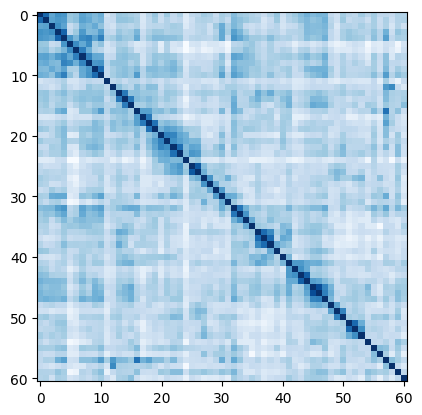

In [39]:
# Set num_topics to be 1/4 of the number of chunks, or 8, which ever is smaller
num_topics = min(int(num_1_chunks / 4), 12)
topics_out = get_topics(stage_1_summaries, stage_1_titles, num_1_chunks, num_topics = num_topics, bonus_constant = 0.4)
chunk_topics = topics_out['chunk_topics']
topics = topics_out['topics']

In [40]:
topics

[[0, 1, 2, 3, 4, 5, 6, 7, 8],
 [9, 10],
 [11, 12, 13, 14, 15],
 [16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26],
 [27, 28, 29, 30, 31],
 [32, 33, 34, 35],
 [36, 37, 38, 39, 40],
 [41, 42, 43, 44],
 [48, 45, 46, 47],
 [49, 50, 51, 52, 53, 54],
 [55, 56, 57, 58, 59, 60]]

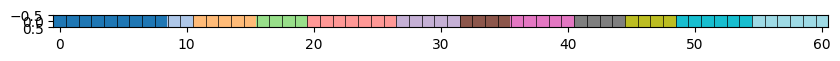

In [41]:
# Plot a heatmap of this array
plt.figure(figsize = (10, 4))
plt.imshow(np.array(chunk_topics).reshape(1, -1), cmap = 'tab20')
# Draw vertical black lines for every 1 of the x-axis 
for i in range(1, len(chunk_topics)):
    plt.axvline(x = i - 0.5, color = 'black', linewidth = 0.5)

## Stage 2: Final Summaries

Using the topics identified prior to this step, we use the same prompt chaining approach to create a summary then title for each topic.  At this point, we have a **first draft** for each topic where the LLM was able to produce an informative article and title.

### v2

In [42]:
def summary_stage_2(summary_data, topics, summary_num_words = 250):
    
    start_time = time.time()
  
    # Prompt to get title and summary for each chunk
    map_prompt_template = """Write a """ + str(summary_num_words) + """ word blog post of the following text.  Include as much information as possible:
  
    {text}
    """
    
    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison",
        max_output_tokens=512,
        temperature=0.3,
        top_p=0.8,
        top_k=40,
        verbose=True,)
  
    topics_data = []
    for c in topics:
        topic_data_temp = [stage_1_summaries[chunk_id] for chunk_id in c]
        topic_data_temp = '. '.join(topic_data_temp)
        topics_data.append(topic_data_temp)

    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in topics_data]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_2_outputs_summary = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Summary creation - Stage 2: {total_time} minutes')

    return {
        'stage_2_outputs_summary': stage_2_outputs_summary
    }

In [43]:
def title_stage_2(summary_data, topics, summary_num_words = 250):
    
    start_time = time.time()

    # Prompt to get title and summary for each chunk
    map_prompt_template = """Write a short title of the following text.  Do not include an explanation:

    {text}
    """

    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

    # Define the LLMs
    map_llm = VertexAI(model_name="text-bison",
        max_output_tokens=256,
        temperature=0.3,
        top_p=0.8,
        top_k=40,
        verbose=True,)
        
    map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
    map_llm_chain_input = [{'text': t} for t in summary_data]
    # Run the input through the LLM chain (works in parallel)
    map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

    stage_2_outputs_title = [e['text'] for e in map_llm_chain_results]

    end_time = time.time()
    total_time = (end_time - start_time)/60
    print(f'Title creation - Stage 2: {total_time} minutes')

    return {
        'stage_2_outputs_title': stage_2_outputs_title
    }

In [44]:
def article_stage_2(stage_1_summaries, num_drafts=3):
    # set number of drafts to generate
    NUM_DRAFTS = 3

    # Query Palm 2 to get a summary and title for each topic
    drafts = []
    for i in range(0, NUM_DRAFTS):
        print(f"Draft {i}")
        stage_2_outputs_summary = summary_stage_2(stage_1_summaries, topics, summary_num_words = 250)['stage_2_outputs_summary']
        stage_2_outputs_title = title_stage_2(stage_2_outputs_summary, topics, summary_num_words = 250)['stage_2_outputs_title']
        drafts.append([i+1, stage_2_outputs_title, stage_2_outputs_summary])
    
    return {
        'drafts': drafts
    }

In [45]:
drafts = article_stage_2(stage_1_summaries, num_drafts=3)['drafts']

Draft 0
Summary creation - Stage 2: 1.202795946598053 minutes
Title creation - Stage 2: 0.1346288522084554 minutes
Draft 1
Summary creation - Stage 2: 1.2179577668507895 minutes
Title creation - Stage 2: 0.1951480507850647 minutes
Draft 2
Summary creation - Stage 2: 1.250197696685791 minutes
Title creation - Stage 2: 0.13742696444193522 minutes


In [46]:
drafts[0][1]

[' Cowboys Chemistry Not an Issue',
 ' Are the Dallas Cowboys Dealing With Chemistry Issues?',
 " Today's Headlines",
 ' Texas Heat Wave: People Are Cooking Food on the Sidewalk',
 ' California vs. Texas:  Cost of Living',
 " \nFormer teacher attacked in her home; Shrimp fisherman reunited with earring lost at sea 23 years ago; Man finds message in a bottle thrown overboard 36 years earlier; Letter likely damaged by neighbor's tree; Men get into fight at Sonic and Tolsa, one man runs flag pole through other's head",
 ' Evolution of Quarterback Usage in the NFL',
 " Astros' Valdez throws 16th no-hitter in franchise history",
 ' Golf, Avery, and Hitskis',
 ' Doris Burke joins ESPN and ABC, Jakez Williams arrested for robbery, Norm Hitskas retires after 48 years',
 ' Armed Robbery, Marital Problems, and Friday Morning Scatter Shooting',
 ' Today in Texas']

In [47]:
import IPython
for i in range(len(drafts)):
    display(IPython.display.Markdown('# DRAFT ' + str(drafts[i][0])))
    for j in range(len(drafts[i][1])):
        if drafts[i][1][j] != "":
            if drafts[i][2][j] != "":
                display(IPython.display.Markdown('### ' + drafts[i][1][j]))
                display(IPython.display.Markdown(drafts[i][2][j]))
                #print(drafts[i][2][j])
                print('------------------------')

# DRAFT 1

###  Cowboys Chemistry Not an Issue

 There was a recent incident in practice where Stefon Diggs and Dak Prescott had a verbal altercation.  Some people believe that this incident is a sign of tension between Diggs and Prescott.  Head coach Mike McCarthy downplayed the incident, saying that it is normal for teammates to talk trash to each other in practice.  Overall, it appears that the incident between Diggs and Prescott was just a minor disagreement that has been blown out of proportion by the media.

Trash-talking is part of the environment in the NFL.  Chemistry issues usually surface after a bad start to the regular season.  The Cowboys may have had a chemistry issue two years ago when they faced the 49ers in the playoffs.  The Cowboys seem to have cured their chemistry issue last year.  The Cowboys seem more confident and together than any team in recent memory.  Mike McCarthy and Will McClay deserve credit for this, as they have drafted players like Dax who fit this mold.

The Dallas Cowboys do not have a chemistry problem.  The author cites the team's ability to rally around backup quarterback Cooper Rush when Dak Prescott was injured as evidence of this.  The author also points to the leadership of players like Amari Cooper and DeMarcus Lawrence as reasons why the team's chemistry is not a problem.  The author believes that the recent reports of chemistry problems within the team are overblown and that the Cowboys should not be concerned about them.

------------------------


###  Are the Dallas Cowboys Dealing With Chemistry Issues?

 Are the Dallas Cowboys Dealing With Chemistry Issues?

The Dallas Cowboys are one of the most popular and valuable sports franchises in the world. They have a rich history, a passionate fan base, and a lot of money. However, they have not won a Super Bowl since 1995.

There are a lot of reasons why the Cowboys have not been able to win a Super Bowl in recent years. Some people say that it is because they have not had a good enough quarterback. Others say that it is because they have not had a good enough defense. Still, others say that it is because they have not had good enough coaching.

One possible reason why the Cowboys have not been able to win a Super Bowl is that they have chemistry issues. Chemistry is important for any team, but it is especially important for a team that has a lot of star players. If the players on a team do not get along, it can be difficult for them to win games.

There have been some reports that the Cowboys have chemistry issues. These reports have come from local beat riders, who are more likely to have inside information about the team. However, there have also been reports that the Cowboys do not have chemistry issues. These reports have come from national reporters, who are more likely to publish clickbait headlines without any substance.

So, what is the truth? Do the Cowboys have chemistry issues? It is difficult to say for sure. There is some evidence to suggest that they do, but there is also evidence to suggest that they do not.

One thing is for sure: if the Cowboys want to win a Super Bowl, they need to find a way to improve their chemistry.

------------------------


###  Today's Headlines

 It is vital to be prepared for storms by having a contractor in place before one hits. Storms can cause damage to many things, including roofing, air conditioning units, siding, and windows. By being prepared, you can reduce the anxiety that comes with needing a contractor at the last minute.

Earlier accident on I35 northbound at Dezing Curve has been cleared but traffic is still slow from Keish Boulevard. Accident on 635 southbound at Oats Drive involving an 18 wheeler has been cleared and traffic is unwinding from Ferguson Road. Fort Worth is currently incident free.

The Fort Worth Rangers swept the Chicago White Sox 18-4. Dane Dunning, Martin Perez, and Max Scherzer all earned wins. After allowing a three-run first, Scherzer struck out nine in six innings yesterday afternoon and retired 13 of the last 14 batters he faced. He said, "You find out about yourself when things don't break your way...It's then what you do then, that's when you find out who you are about a pitcher."

The Chicago White Sox defeated the Texas Rangers by a score of 18-4. Andreeni, Dane Dunning, and Max Sherser all earned wins for the White Sox. Sherser struck out nine batters in six innings and retired 13 of the last 14 batters he faced.

In other news, Big 12 executives met Thursday to approve an application for Arizona to join the conference. The Arizona Board of Regents reportedly met last night to vote on the move. A formal approval is expected to be finalized soon.

Finally, Cowboy's defensive tackle OSO Digizua will join users live from training camp in Oxnard at 8:55 this morning.

------------------------


###  Texas Heat Wave: People Are Cooking Food on the Sidewalk

 **Texas Heat Wave: People Are Cooking Food on the Sidewalk**

Texas is currently experiencing a heat wave with temperatures reaching up to 107 degrees Fahrenheit. In response, people are posting videos online of baking bread and cookies, popping popcorn, and frying eggs on the sidewalk. However, experts warn that these foods are not thoroughly cooked and should not be eaten. 

The heat wave is expected to last for the next week. July 2023 was the hottest month on record across the globe, with temperatures reaching 126 degrees Fahrenheit in China and 128 degrees Fahrenheit in Death Valley. The heat wave is caused by a rash of intense heat domes that have been sprawling across the northern hemisphere. 

The heat wave has also affected Asia, southern Europe, northern Africa, and North America. In the United States, Phoenix had a record-breaking 31 straight days of temperatures reaching 110 degrees or higher. El Paso had 44 days in a row at or above 100 degrees. Miami had 46 straight days with a heat index over 100 degrees. 

In addition to the heat wave, gas prices in North Texas could rise due to Saudi Arabia's decision to extend its unilateral production cut of 1 million barrels of oil per day. This could lead to higher gas prices in North Texas, where the average price per gallon is currently around $3.58.

------------------------


###  California vs. Texas:  Cost of Living

 The cost of living in California is among the highest in the United States. This is largely due to the high cost of housing, which is driven by a number of factors, including the state's strong economy, high demand for housing, and limited supply of land.  The median home price in California is over $600,000, which is more than double the national median. Property taxes are also high in California, averaging over $7,000 per year. This is due to the state's high property values and the fact that California has a relatively low property tax rate.  In contrast, the cost of living in Texas is generally lower than in California. The median home price in Texas is around $200,000, and property taxes are much lower, averaging around $2,500 per year. This is because Texas has a lower property tax rate and a higher state income tax.  The cost of cigarettes is also higher in California than in Texas. A pack of cigarettes costs around $7.62 in California, while it costs around $5.62 in Texas. This is due to the fact that California has a higher cigarette tax than Texas.  Despite the high cost of living, California is still a popular place to live. The state's strong economy, mild climate, and beautiful scenery make it an attractive destination for people from all over the country.

------------------------


###  
Former teacher attacked in her home; Shrimp fisherman reunited with earring lost at sea 23 years ago; Man finds message in a bottle thrown overboard 36 years earlier; Letter likely damaged by neighbor's tree; Men get into fight at Sonic and Tolsa, one man runs flag pole through other's head

  A former elementary school teacher was attacked in her home by a young man. She bravely defended herself with a chair and then offered to make him food. While he was eating, she called the cops.  In a heartwarming story, a shrimp fisherman in the Netherlands lost an earring at sea 23 years ago. Another boat found the earring on their deck 23 years later and posted a picture of it on social media. The original owner saw the post and was reunited with his earring.  A man in a nearby boat recognized the earring and said it was his. The earring was a silhouette of a troller that sank 36 years ago. The man had kept the earring from the boat he had worked on.  The author found a message in a bottle that had been thrown overboard 36 years earlier. The author used to throw messages in bottles into the ocean as a child, and they never got a response. The author thinks it would be cool to find a message in a bottle.  A man received a letter that was likely damaged by his neighbor's tree.  Two men got into an argument at a Sonic and Tolsa.  One of the men picked up a flag pole with an American flag on it and ran it through the other guy's head. The victim survived but will likely lose an eye.

------------------------


###  Evolution of Quarterback Usage in the NFL

 The evolution of quarterback usage in the NFL has been a hot topic of discussion in recent years. Last season, quarterbacks accounted for 20.1% of all rushing touchdowns in the league, compared to only 11% in 2010. This trend is likely due to the increasing importance of mobility and athleticism in the quarterback position. Quarterbacks are now leading the NFL in sales of officially licensed player products, with Patrick Mahomes leading the league in sales during the first quarter of the new NFL calendar. This suggests that the trend is shifting towards dual-threat signal callers, and that the importance of running backs may be declining.

In other news, the "emergency break of the week" has been declared due to the "madness" of the last 36 hours and college realignment. Former Cowboys linebacker Anthony Spencer has announced his retirement from the NFL, and the Red Rocks concert venue has announced its lineup for the upcoming season.

Here are some additional notes from the text:

- 3 Cowboys made the top 10 in jersey sales during the first quarter of the new NFL calendar.
- Dak Prescott is ranked number 7.
- CeeDee Lamb is ranked number 9.
- Many people are wearing jersey number 11, which is likely due to Danny White.
- Danny White is still in the top 10 in jersey sales, even though he retired from the NFL in 1988.

------------------------


###  Astros' Valdez throws 16th no-hitter in franchise history

 Fromber Valdez threw the 16th no-hitter in Astros franchise history this week, a feat that has only been accomplished five times in the history of the Texas Rangers franchise, which was founded a year earlier in 1961. 

The Astros have thrown six no-hitters in their 61-year history, while the Rangers have thrown five in their 62-year history. 

The Dodgers have the most no-hitters in MLB history with 26, followed by the White Sox (20), Red Sox (18), Giants (17), Reds (17), and Cubs (17). 

Among the Astros greats to throw a no-hitter are Nolan Ryan, Mike Scott, Justin Verlander, and the late Don Wilson. 

Over the past five seasons, the Astros have thrown the most no-hitters in Major League Baseball history, with five. 

Starters in the NBA have become more risk-averse, tasked with the low bar of "just don't lose the game, we don't need you to win it, just don't lose it." 

In other news, Luka Doncic recently announced his engagement, and his former Villanova teammate Jalen Brunson got married last weekend. 

Brunson tied the knot with his long-time girlfriend Ali Marx in Chicago, with friend and former Villanova teammate Ryan Arcidiacono officiating the ceremony. 

Many of Brunson's current New York Knicks teammates attended the wedding. 

58 Texas-born golfers have made at least one cut at a PGA event in the last 10 years, second only to California (85). 

Texas has produced the most players in the top 50 of the all-time wins list with seven. 

Ben Hogan leads the list with 64 wins, followed by Byron Nelson (52), Lloyd Mangrum (36), Jimmy Demaret (31), Lee Trevino (29), and Ben Crenshaw and Tom Kite (19 each).

------------------------


###  Golf, Avery, and Hitskis

 Ben Hogan is the most successful golfer in Colonial National Invitation Tournament history, with six wins. Byron Nelson is second with five wins, followed by Lloyd Mangrum with three wins. Jimmy Demaret, Lee Trevino, Ben Crenshaw, and Tom Kite have each won the tournament twice.

In other news, former Dallas Stars player Sean Avery has a minor role in the new film Oppenheimer. Avery appears on screen with Cillian Murphy and Matt Damon while the atomic bomb crew is running tests in New Mexico. Avery's role is so small that he could easily be missed if the viewer was not specifically looking for him. Despite his limited screen time, Avery does have a few speaking lines.

Avery has always been interested in acting and has appeared in a few films during his playing days. He is known for being a controversial player and for his romantic life. In 2017, he was inducted into the Dallas Stars Hall of Fame.

Finally, Norm Hitskis, a longtime sports radio personality in Dallas, was recently honored before a Rangers game and in Peter King's weekly column for his 48-year career in sports radio. Hitskis is known for his encyclopedic knowledge of sports and his ability to connect with listeners. He is a beloved figure in the Dallas sports community.

------------------------


###  Doris Burke joins ESPN and ABC, Jakez Williams arrested for robbery, Norm Hitskas retires after 48 years

 Doris Burke is a well-respected sportscaster who has been in the industry for many years. She is known for her insightful commentary and her ability to connect with viewers. Recently, ESPN and ABC announced that she would be joining their broadcast team for NBA games. This is a great opportunity for Burke, and she is sure to excel in this role.

In other news, Jakez Williams was arrested in Miami for robbing a 68-year-old woman. He took her purse, wallet, and checkbook. This is a despicable crime, and Williams should be punished to the fullest extent of the law.

Finally, Norm Hitskas retired after 48 years on Sports Radio in Dallas. He is known for his enduring care for people struggling in life, and he has raised over $8 million for the Austin Street Center for the homeless through his annual fundraiser. Hitskas has left a lasting legacy in radio and broadcasting, and he will be missed by many.

------------------------


###  Armed Robbery, Marital Problems, and Friday Morning Scatter Shooting

 Williams robbed a 68-year-old Miami woman, taking her purse which contained her wallet and checkbook. He then attempted to go on a shopping spree, but when he tried to check out at the register of a big box store, he wrote a check from the woman's checkbook. Then when asked to present ID, he produced the woman's Florida driver's license, which he had gotten from her wallet that he stole. Williams was arrested and charged with robbery, grand theft, and criminal use of personal identification information.

Jim is having trouble in his marriage. His wife seems to always be angry with him. Jim decided to pay his therapist a visit before he went home. The therapist advised Jim to spend more time with his wife.

Jim goes home and tells his wife that he likes the dinner she made. She gets upset and tells him that she's been cooking for him for 21 years and he's never appreciated it. She says that the one day she gets food from the neighbors, he likes it.

The host thanks the listeners for tuning in to Friday Morning Scatter Shooting. The next segment will be the "Emergency Break of the Week" and will feature a frog, confusion, and a fake f-bomb.

------------------------


###  Today in Texas

 Today in Texas, there is a heat wave.  If you sign up for TXU, you can save money.  There was an accident on 287 Northbound approaching i-30 in Fort Worth, but it has been cleared and traffic is moving freely.  In Plano, 75 Northbound at the Bush Turnpike had a disabled vehicle blocking the HOV lane, but that has been cleared and traffic is moving freely.  A man died in a toilet.  He had gotten up in the toilet, fell forward, and bit his tongue in half.  His tongue was found still moving and singing.  One of the hosts, Mike, is on drugs.  Ty Walker is a candidate for an unspecified position.  He is known for his catchphrase "Ty for a huge matchup next on the top 10."

------------------------


# DRAFT 2

###  Cowboys Chemistry Not A Problem

 There was a recent incident in practice where Stefon Diggs and Dak Prescott had a verbal altercation.  Some people believe that this incident is a sign of tension between Diggs and Prescott.  Head coach Mike McCarthy downplayed the incident, saying that it is normal for teammates to talk trash to each other in practice.  Overall, it appears that the incident between Diggs and Prescott was just a minor disagreement that has been blown out of proportion by the media.

Trash-talking is part of the environment in the NFL.  Chemistry issues usually surface after a bad start to the regular season.  The Cowboys may have had a chemistry issue two years ago when they faced the 49ers in the playoffs.  The Cowboys seem to have cured their chemistry issue last year.  The Cowboys seem more confident and together than any team in recent memory.  Mike McCarthy and Will McClay deserve credit for this, as they have drafted players like Dax who fit this mold.

The Dallas Cowboys do not have a chemistry problem.  The team's ability to rally around backup quarterback Cooper Rush when Dak Prescott was injured is evidence of this.  The leadership of players like Amari Cooper and DeMarcus Lawrence is also a reason why the team's chemistry is not a problem.  The recent reports of chemistry problems within the team are overblown and the Cowboys should not be concerned about them.

------------------------


###  Are the Dallas Cowboys Dealing With Chemistry Issues?

 Are the Dallas Cowboys Dealing With Chemistry Issues?
The Dallas Cowboys are one of the most popular and successful NFL teams in history. However, they have not won a Super Bowl since 1995. Some people believe that the Cowboys' lack of recent success is due to chemistry issues within the team.

Local beat riders are more likely to have inside information about the Dallas Cowboys and their chemistry issues. National sites are more likely to publish clickbait headlines without any substance. 

There are a couple of national reporters who are highly respected and highly tied in, such as Peter King. If you just see a clickbait headline about Cowboys' chemistry issues and there's nothing being reported locally about it, it's probably not a story.

However, there are some signs that the Cowboys may have a chemistry problem. The team has been plagued by injuries in recent years, and some players have been vocal about their unhappiness with the organization. In addition, the Cowboys have not been able to consistently win big games.

If the Cowboys want to be successful, they will need to address their chemistry issues. The team needs to find a way to get everyone on the same page and working towards a common goal. If they can do that, they will be a force to be reckoned with in the NFL.

------------------------


###  Today's Headlines

 It is vital to be prepared for storms by having a contractor in place before one hits. Storms can cause damage to many things, including roofing, air conditioning units, siding, and windows. By being prepared, you can reduce the anxiety that comes with needing a contractor at the last minute.

Earlier accident on I35 northbound at Dezing Curve has been cleared but traffic is still slow from Keish Boulevard. Accident on 635 southbound at Oats Drive involving an 18 wheeler has been cleared and traffic is unwinding from Ferguson Road. Fort Worth is currently incident free.

The Fort Worth Rangers swept the Chicago White Sox 18-4. Dane Dunning, Martin Perez, and Max Scherzer all earned wins. After allowing a three-run first, Scherzer struck out nine in six innings yesterday afternoon and retired 13 of the last 14 batters he faced. He said, "You find out about yourself when things don't break your way...It's then what you do then, that's when you find out who you are about a pitcher."

The Chicago White Sox defeated the Texas Rangers by a score of 18-4. Andreeni, Dane Dunning, and Max Sherser all earned wins for the White Sox. Sherser struck out nine batters in six innings and retired 13 of the last 14 batters he faced.

In other news, Big 12 executives met Thursday to approve an application for Arizona to join the conference. The Arizona Board of Regents reportedly met last night to vote on the move. A formal approval is expected to be finalized soon.

Finally, Cowboy's defensive tackle OSO Digizua will join users live from training camp in Oxnard at 8:55 this morning.

------------------------


###  Texas Heat Wave: People Are Cooking Food on the Sidewalk

 **Texas Heat Wave: People Are Cooking Food on the Sidewalk**

Texas is currently experiencing a heat wave with temperatures reaching up to 107 degrees Fahrenheit. In response, people are posting videos online of baking bread and cookies, popping popcorn, and frying eggs on the sidewalk. However, experts warn that these foods are not thoroughly cooked and should not be eaten. 

The heat wave is expected to last for the next week. July 2023 was the hottest month on record across the globe, with temperatures reaching 126 degrees Fahrenheit in China and 128 degrees Fahrenheit in Death Valley. The heat wave is caused by a rash of intense heat domes that have been sprawling across the northern hemisphere. 

The heat wave has also affected Asia, southern Europe, northern Africa, and North America. In the United States, Phoenix had a record-breaking 31 straight days of temperatures reaching 110 degrees or higher. El Paso had 44 days in a row at or above 100 degrees. Miami had 46 straight days with a heat index over 100 degrees. 

In addition to the heat wave, gas prices in North Texas could rise due to Saudi Arabia's decision to extend its unilateral production cut of 1 million barrels of oil per day. This could lead to higher gas prices in North Texas, where the average price per gallon is currently around $3.58.

------------------------


###  Cigarette Taxes and Smoking Rates in California and Texas

 The cost of living in California is among the highest in the United States. This is due in large part to the high cost of housing and property taxes. In Texas, property taxes are lower, but state income taxes are higher. 

The cost of cigarettes is also higher in California than in Texas. A pack of cigarettes costs around $7.62 in Texas, while it costs around $11.96 in California. This is due to the higher state excise tax on cigarettes in California.

Smoking is an expensive habit, and it can also lead to health problems. The cost of cigarettes and cancer treatment can be a significant financial burden. In addition to the financial costs, smoking can also have a negative impact on one's health and well-being.

------------------------


###  Incredible Stories

 Incredible Stories That Will Make You Think
Have you ever wondered what would happen if you found a message in a bottle? Or if you lost an earring at sea and it was found 23 years later? These are just a few of the incredible stories that will make you think.

In one story, a former elementary school teacher was attacked in her home by a young man. She bravely defended herself with a chair and then offered to make him food. While he was eating, she called the cops. This story is a reminder that even in the most dangerous of situations, there is always hope.

In another story, a shrimp fisherman in the Netherlands lost an earring at sea 23 years ago. Another boat found the earring on their deck 23 years later and posted a picture of it on social media. The original owner saw the post and was reunited with his earring. This story is a reminder that even the most lost things can be found again.

Finally, one man received a letter that was likely damaged by his neighbor's tree. The letter was addressed to someone else, but the man decided to open it anyway. Inside, he found a beautiful poem. This story is a reminder that sometimes, the most unexpected things can bring us joy.

These are just a few of the incredible stories that will make you think. They are a reminder that life is full of surprises, and that anything is possible.

------------------------


###  QBs lead NFL in jersey sales

 The NFL is seeing a rising trend in dual-threat quarterbacks, with quarterbacks accounting for 20.1% of all rushing touchdowns in the league last season, up from 11% in 2010. Quarterbacks are now leading the NFL in sales of officially licensed player products, with Patrick Mahomes leading the league in sales during the first quarter of the new NFL calendar. This suggests that the trend is shifting towards dual-threat signal callers, and that the importance of running backs may be declining.

The Cowboys are no exception to this trend, with Dak Prescott and CeeDee Lamb both making the top 10 in jersey sales during the first quarter of the new NFL calendar. Interestingly, a lot of people are also wearing jersey number 11, which is most likely a nod to former Cowboys quarterback Danny White, who is still in the top 10 in jersey sales.

------------------------


###  Astros' Valdez throws 16th no-hitter in franchise history

 Fromber Valdez threw the 16th no-hitter in Astros franchise history this week, a feat that has only been accomplished five times in the history of the Texas Rangers franchise, which was founded a year earlier in 1961. 

The Astros have thrown six no-hitters in their 61-year history, while the Rangers have thrown five in their 62-year history. 

The Dodgers have the most no-hitters in MLB history with 26, followed by the White Sox (20), Red Sox (18), Giants (17), Reds (17), and Cubs (17). 

Among the Astros greats to throw a no-hitter are Nolan Ryan, Mike Scott, Justin Verlander, and the late Don Wilson. 

Over the past five seasons, the Astros have thrown the most no-hitters in Major League Baseball history, with five. 

Starters in the NBA have become more risk-averse, tasked with the low bar of "just don't lose the game, we don't need you to win it, just don't lose it." 

In other news, Luka Doncic recently announced his engagement, and his former Villanova teammate Jalen Brunson got married last weekend. 

Brunson tied the knot with his long-time girlfriend Ali Marx in Chicago, with friend and former Villanova teammate Ryan Arcidiacono officiating the ceremony. 

Many of Brunson's current New York Knicks teammates attended the wedding. 

58 Texas-born golfers have made at least one cut at a PGA event in the last 10 years, second only to California (85). 

Texas has produced the most players in the top 50 of the all-time wins list with seven. 

Ben Hogan leads the list with 64 wins, followed by Byron Nelson (52), Lloyd Mangrum (36), Jimmy Demaret (31), Lee Trevino (29), and Ben Crenshaw and Tom Kite (19 each).

------------------------


###  Ben Hogan dominates Colonial; Sean Avery cameos in Oppenheimer; Norm Hitzkis honored

 Ben Hogan is the most successful golfer in Colonial National Invitation Tournament history, with six wins. Byron Nelson is second with five wins, followed by Lloyd Mangrum with three wins. Jimmy Demaret, Lee Trevino, Ben Crenshaw, and Tom Kite have each won the tournament twice.

In other news, former Dallas Stars player Sean Avery has a minor role in the new movie Oppenheimer. Avery appears on screen with Cillian Murphy and Matt Damon while the atomic bomb crew is running tests in New Mexico. 

Avery has always been interested in acting and has appeared in a few films during his playing days. He is known for being a controversial player and for his romantic life.

Finally, Norm Hitskis, a longtime sports radio personality in Dallas, was recently honored before a Rangers game and in Peter King's weekly column for his 48-year career in sports radio. Hitskis is known for his encyclopedic knowledge of sports and his entertaining interviews.

------------------------


###  Doris Burke joins ESPN and ABC, Norm Hitskas retires after 48 years, and Jakez Williams arrested for robbery

 Doris Burke is a well-respected sportscaster who has been in the industry for many years. She is known for her insightful commentary and her ability to connect with viewers. Recently, ESPN and ABC announced that she would be joining their broadcast team for NBA games. This is a great opportunity for Burke, and she is sure to excel in her new role.

In other news, Norm Hitskas, a legendary sportscaster in Dallas, has retired after 48 years on the air. Hitskas is known for his passion for sports and his dedication to his community. He has raised over $8 million for the Austin Street Center for the Homeless through his annual fundraiser. He will be missed by many, but his legacy will live on.

Finally, Jakez Williams, a 26-year-old man, was arrested in Miami for robbing a 68-year-old woman. Williams took the woman's purse, wallet, and checkbook. He is currently being held in jail and awaiting trial.

------------------------


###  1.  Robbery, Grand Theft, and Criminal Use of Personal Identification Information
2.  Jim's Marital Problems
3.  Emergency Break of the Week

 Williams robbed a 68-year-old Miami woman, taking her purse which contained her wallet and checkbook. He then attempted to go on a shopping spree, but when he tried to check out at the register of a big box store, he wrote a check from the woman's checkbook. Then when asked to present ID, he produced the woman's Florida driver's license, which he had gotten from her wallet that he stole. Williams was arrested and charged with robbery, grand theft, and criminal use of personal identification information.

Jim is having trouble in his marriage. His wife seems to always be angry with him. Jim decided to pay his therapist a visit before he went home. The therapist advised Jim to spend more time with his wife.

Jim goes home and tells his wife that he likes the dinner she made. She gets upset and tells him that she's been cooking for him for 21 years and he's never appreciated it. She says that the one day she gets food from the neighbors, he likes it.

The host thanks the listeners for tuning in to Friday Morning Scatter Shooting. The next segment will be the "Emergency Break of the Week" and will feature a frog, confusion, and a fake f-bomb.

------------------------


###  Today in Texas

 Today in Texas, there is a heat wave.  If you sign up for TXU, you can save money.  There was an accident on 287 Northbound approaching i-30 in Fort Worth.  The accident has been cleared and traffic is moving freely.  In Plano, 75 Northbound at the Bush Turnpike had a disabled vehicle blocking the HOV lane, but that has been cleared and traffic is moving freely.  A man died in a toilet.  He had gotten up in the toilet, fell forward, and bit his tongue in half.  His tongue was found still moving and singing.  One of the hosts, Mike, is on drugs.  Ty Walker is a candidate for an unspecified position.  He is known for his catchphrase "Ty for a huge matchup next on the top 10."

------------------------


# DRAFT 3

###  Cowboys have no chemistry issues

 There was a recent incident in practice where Stefon Diggs and Dak Prescott had a verbal altercation.  Some people believe that this incident is a sign of tension between Diggs and Prescott.  Head coach Mike McCarthy downplayed the incident, saying that it is normal for teammates to talk trash to each other in practice.  Overall, it appears that the incident between Diggs and Prescott was just a minor disagreement that has been blown out of proportion by the media.  Trash-talking is part of the environment in the NFL.  Chemistry issues usually surface after a bad start to the regular season.  The Cowboys may have had a chemistry issue two years ago when they faced the 49ers in the playoffs.  The Cowboys seem to have cured their chemistry issue last year.  The Cowboys seem more confident and together than any team in recent memory.  Mike McCarthy and Will McClay deserve credit for this, as they have drafted players like Dax who fit this mold.  The text suggests that the Dallas Cowboys have intentionally built a team of players who are not only talented, but also have good character.  The author believes that the Dallas Cowboys do not have a chemistry problem.

------------------------


###  Are the Dallas Cowboys Having Chemistry Issues?

 Are the Dallas Cowboys Having Chemistry Issues?

The Dallas Cowboys are one of the most popular and successful NFL teams in history. However, they have not won a Super Bowl since 1995. Some people believe that the Cowboys' lack of recent success is due to chemistry issues within the team.

Local beat riders are more likely to have inside information about the Cowboys and their chemistry issues. National sites are more likely to publish clickbait headlines without any substance. However, there are a few national reporters, such as Peter King, who are highly respected and have good sources.

If you just see a clickbait headline about Cowboys chemistry issues and there's nothing being reported locally about it, it's probably not a story. However, if there are multiple reports from local beat riders about chemistry issues, then there may be something to the story.

The Cowboys may have a chemistry problem. However, it is important to remember that chemistry issues are not always the cause of a team's lack of success. There are many other factors that can contribute to a team's success or failure, such as coaching, injuries, and luck.

------------------------


###  Today's Headlines

 It is vital to be prepared for storms by having a contractor in place before one hits. Storms can cause damage to many things, including roofing, air conditioning units, siding, and windows. By being prepared, you can reduce the anxiety that comes with needing a contractor at the last minute.

Earlier accident on I35 northbound at Dezing Curve has been cleared but traffic is still slow from Keish Boulevard. Accident on 635 southbound at Oats Drive involving an 18 wheeler has been cleared and traffic is unwinding from Ferguson Road. Fort Worth is currently incident free.

The Fort Worth Rangers swept the Chicago White Sox 18-4. Dane Dunning, Martin Perez, and Max Scherzer all earned wins. After allowing a three-run first, Scherzer struck out nine in six innings yesterday afternoon and retired 13 of the last 14 batters he faced. He said, "You find out about yourself when things don't break your way...It's then what you do then, that's when you find out who you are about a pitcher."

The Chicago White Sox defeated the Texas Rangers by a score of 18-4. Andreeni, Dane Dunning, and Max Sherser all earned wins for the White Sox. Sherser struck out nine batters in six innings and retired 13 of the last 14 batters he faced.

In other news, Big 12 executives met Thursday to approve an application for Arizona to join the conference. The Arizona Board of Regents reportedly met last night to vote on the move. A formal approval is expected to be finalized soon.

Finally, Cowboy's defensive tackle OSO Digizua will join users live from training camp in Oxnard at 8:55 this morning.

------------------------


###  Texas Heat Wave: People Are Cooking Food on the Sidewalk

 **Texas Heat Wave: People Are Cooking Food on the Sidewalk**

Texas is currently experiencing a heat wave with temperatures reaching up to 107 degrees Fahrenheit. In response, people are posting videos online of baking bread and cookies, popping popcorn, and frying eggs on the sidewalk. However, experts warn that these foods are not thoroughly cooked and should not be eaten. The heat wave is expected to last for the next week.

July 2023 was the hottest month on record across the globe, with temperatures reaching 126 degrees Fahrenheit in China and 128 degrees Fahrenheit in Death Valley. The heat wave is caused by a rash of intense heat domes that have been sprawling across the northern hemisphere. The heat wave has also affected Asia, southern Europe, northern Africa, and North America.

In the United States, Phoenix had a record-breaking 31 straight days of temperatures reaching 110 degrees or higher. El Paso had 44 days in a row at or above 100 degrees. Miami had 46 straight days with a heat index over 100 degrees.

The heat wave is having a significant impact on people's lives. Many people are staying indoors and avoiding going outside. Those who do go outside are taking precautions, such as wearing sunscreen, drinking plenty of water, and seeking shade.

The heat wave is also having an impact on the economy. Gas prices in North Texas could rise due to Saudi Arabia's decision to extend its unilateral production cut of 1 million barrels of oil per day. This could lead to higher gas prices in North Texas, where the average price per gallon is currently around $3.58.

The high cost of gas and cigarettes in Dallas, Fort Worth, and California was also discussed.

------------------------


###  California vs. Texas: Which is More Affordable?

 The cost of living in California is among the highest in the United States, and housing is a major factor. The median home price in California is over $600,000, more than double the national median. Property taxes are also high, with California having the highest effective property tax rate in the country. 

     One alternative to California is Texas, which has a lower cost of living. The median home price in Texas is around $250,000, and property taxes are lower. However, Texas does not have a state income tax, which means that residents pay more in state income taxes than they would in California. 

     Another factor to consider is the cost of cigarettes. Cigarettes are more expensive in California than in Texas. A pack of cigarettes costs around $7.62 in California, while it costs around $6.21 in Texas. 

     Ultimately, the decision of whether to live in California or Texas depends on a variety of factors, including housing costs, property taxes, and the cost of cigarettes.

------------------------


###  Incredible Stories

  A former elementary school teacher was attacked in her home by a young man. She bravely defended herself with a chair and then offered to make him food. While he was eating, she called the cops. In a separate story, a shrimp fisherman in the Netherlands lost an earring at sea 23 years ago. Another boat found the earring on their deck 23 years later and posted a picture of it on social media. The original owner saw the post and was reunited with his earring. 
In another incredible story, a man found a message in a bottle that had been thrown overboard 36 years earlier. The author used to throw messages in bottles into the ocean as a child, and they never got a response. The author thinks it would be cool to find a message in a bottle. 
Lastly, a man received a letter that was likely damaged by his neighbor's tree.  Two men got into an argument at a Sonic and Tolsa.  One of the men picked up a flag pole with an American flag on it and ran it through the other guy's head.  The victim survived but will likely lose an eye.

------------------------


###  Evolution of Quarterback Usage in the NFL

 Quarterback Usage in the NFL: A Look at the Evolution of the Position

The NFL has seen a significant evolution in the usage of quarterbacks over the past decade. In 2010, quarterbacks accounted for only 11% of all rushing touchdowns in the league. Last season, that number had jumped to 20.1%. This trend is likely due to the increasing importance of mobility and athleticism in the quarterback position.

This trend is also reflected in the sales of officially licensed player products. Quarterbacks now lead the NFL in sales, with Patrick Mahomes leading the league in sales during the first quarter of the new NFL calendar. This suggests that the trend is shifting towards dual-threat signal callers, and that the importance of running backs may be declining.

The Cowboys are no exception to this trend. Three Cowboys made the top 10 in sales of officially licensed player products, with Dak Prescott at number 7 and CeeDee Lamb at number 9. Interestingly, a lot of people are also wearing jersey number 11, which is most likely a nod to former Cowboys quarterback Danny White. White is still in the top 10 in jersey sales, even though he retired over 30 years ago.

The evolution of quarterback usage in the NFL is a fascinating one to watch. It will be interesting to see how the position continues to change in the years to come.

------------------------


###  Astros' Valdez throws 16th no-hitter in franchise history

 Fromber Valdez threw the 16th no-hitter in Astros franchise history this week, a feat that has only been accomplished five times in the history of the Texas Rangers franchise, which was founded a year earlier in 1961. 

The Astros have thrown six no-hitters in their 61-year history, while the Rangers have thrown five in their 62-year history. 

The Dodgers have the most no-hitters in MLB history with 26, followed by the White Sox (20), Red Sox (18), Giants (17), Reds (17), and Cubs (17). 

Among the Astros greats to throw a no-hitter are Nolan Ryan, Mike Scott, Justin Verlander, and the late Don Wilson. 

Over the past five seasons, the Astros have thrown the most no-hitters in Major League Baseball history, with five. 

Starters in the NBA have become more risk-averse, tasked with the low bar of "just don't lose the game, we don't need you to win it, just don't lose it." 

In other news, Luka Doncic recently announced his engagement, and his former Villanova teammate Jalen Brunson got married last weekend. 

Brunson tied the knot with his long-time girlfriend Ali Marx in Chicago, with friend and former Villanova teammate Ryan Arcidiacono officiating the ceremony. 

Many of Brunson's current New York Knicks teammates attended the wedding. 

58 Texas-born golfers have made at least one cut at a PGA event in the last 10 years, second only to California (85). 

Texas has produced the most players in the top 50 of the all-time wins list with seven. 

Ben Hogan leads the list with 64 wins, followed by Byron Nelson (52), Lloyd Mangrum (36), Jimmy Demaret (31), Lee Trevino (29), and Ben Crenshaw and Tom Kite (19 each).

------------------------


###  Ben Hogan Tops Colonial; Sean Avery in Oppenheimer; Norm Hitzkis Honored

 Ben Hogan is the most successful golfer in Colonial National Invitation Tournament history, with six victories. Byron Nelson is second with five wins, followed by Lloyd Mangrum with three, Jimmy Demaret with three, Lee Trevino with two, and Ben Crenshaw and Tom Kite with one each.

In other news, former Dallas Stars player Sean Avery has a minor role in the new movie Oppenheimer. Avery appears on screen with Cillian Murphy and Matt Damon while the atomic bomb crew is running tests in New Mexico. 

Avery has always been interested in acting and has appeared in a few films during his playing days. He is known for being a controversial player and for his romantic life.

Finally, Norm Hitskis, a longtime sports radio personality in Dallas, was recently honored before a Rangers game and in Peter King's weekly column for his 48-year career in sports radio. Hitskis is known for his encyclopedic knowledge of sports and his entertaining interviews.

------------------------


###  Doris Burke joins ESPN and ABC, Norm Hitskas retires, and Jakez Williams robs elderly woman

 Doris Burke is a well-respected sportscaster who has been in the industry for many years. She is known for her insightful commentary and her ability to connect with viewers. Recently, ESPN and ABC announced that she would be joining their broadcast team for NBA games. This is a great opportunity for Burke, and she is sure to excel in this new role.

In other news, Norm Hitskas retired after 48 years on Sports Radio in Dallas. Hitskas was known for his enduring care for people struggling in life, and he raised over $8 million for the Austin Street Center for the homeless through his annual fundraiser. He will be missed by his colleagues and listeners alike.

Finally, Jakez Williams robbed a 68-year-old woman in Miami. He took her purse, wallet, and checkbook. Williams was later arrested and charged with robbery. This is a reminder to be aware of your surroundings and to take precautions to protect yourself from crime.

------------------------


###  Armed Robbery, Marital Problems, and Friday Morning Scatter Shooting

 Williams robbed a 68-year-old Miami woman, taking her purse which contained her wallet and checkbook. He then attempted to go on a shopping spree, but when he tried to check out at the register of a big box store, he wrote a check from the woman's checkbook. Then when asked to present ID, he produced the woman's Florida driver's license, which he had gotten from her wallet that he stole. Williams was arrested and charged with robbery, grand theft, and criminal use of personal identification information.

Jim is having trouble in his marriage. His wife seems to always be angry with him. Jim decided to pay his therapist a visit before he went home. The therapist advised Jim to spend more time with his wife.

Jim goes home and tells his wife that he likes the dinner she made. She gets upset and tells him that she's been cooking for him for 21 years and he's never appreciated it. She says that the one day she gets food from the neighbors, he likes it.

The host thanks the listeners for tuning in to Friday Morning Scatter Shooting. The next segment will be the "Emergency Break of the Week" and will feature a frog, confusion, and a fake f-bomb.

------------------------


###  Modern-Day Marriage Proposal Gone Wrong

 250 word blog post:
  
The post begins by stating that certain products are not intended to diagnose, treat, cure, or prevent any disease or illness. It then provides an example of a modern-day marriage proposal, in which the participants use their smartphones to record the event.  A young man professes his love to a woman through text message. She accepts, and they exchange kissing emojis and hearts. The man then puts his phone down, shocking the observer..  The key points of the text are: 1. There is a heat wave in Texas. 2. You can save money by signing up for TXU. 3. There was an accident on 287 Northbound approaching i-30 in Fort Worth. 4. The accident has been cleared and traffic is moving freely..  287 Northbound approaching i-30 has been cleared and traffic is moving freely. In Plano, 75 Northbound at the Bush Turnpike had a disabled vehicle blocking the HOV lane, but that has been cleared and traffic is moving freely..  The text is about a man who died in a toilet. He had gotten up in the toilet, fell forward, and bit his tongue in half. His tongue was found still moving and singing. The text also mentions that Mike, one of the hosts, is on drugs..  Ty Walker is a candidate for an unspecified position. He is known for his catchphrase "Ty for a huge matchup next on the top 10."

------------------------


## UI (WIP)

In [199]:
def upload_file(file):
    file_path = file.name
    file_name = os.path.basename(file_path)
    bucket = gcs.bucket(GCS_BUCKET)
    blob = bucket.blob(f'audio_data/cumulus/{file_name}')
    blob.upload_from_filename(f'{file_path}')
    #print("Uploaded")
    
    gcs_path = f'gs://{GCS_BUCKET}/{blob.name}'
    
    return gcs_path
    
#with gr.Blocks() as demo:
#    file_output = gr.File()
#    upload_button = gr.UploadButton("Click to Upload a File", file_types=["audio"])
#    upload_button.upload(upload_file, upload_button, file_output)

#demo.launch(share=False, debug=False)

In [ ]:
# create a function that pulls all the steps together
def article_builder(gcs_uri):
    

In [187]:
get_audio_data('mg-ce-demos')

[['audio_data/cumulus/KTCKFMAirMonitor-23-2023-08-04_07-00-01-288.mp3',
  'audio/mpeg',
  'gs://mg-ce-demos/audio_data/cumulus/KTCKFMAirMonitor-23-2023-08-04_07-00-01-288.mp3']]

In [201]:
import gradio as gr

demo = gr.Blocks()

with demo:
    audio_file = gr.Audio(type="filepath")
    text = gr.Textbox()
    label = gr.Label()

    b1 = gr.Button("Upload")
    b2 = gr.Button("Get GCS URI")
    b3 = gr.Button("Create Articles")

    b1.click(upload_file, inputs=audio_file, outputs=text)
    b2.click(get_audio_data, inputs=text, outputs=label)

if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7892

To create a public link, set `share=True` in `launch()`.


In [194]:

with gr.Blocks() as demo:
    gr.Markdown(
    """
    ## Audio to Articles
    """)
    #with gr.Row():
    #    file_output = gr.File()
    #    upload_button = gr.UploadButton("Click to Transcribe and Draft Articles", file_types=["audio"])
    #    upload_button.upload(upload_file, upload_button, file_output)  
        
    with gr.Row():
        with gr.Column():
            input_text = gr.Textbox(label="Task", placeholder="Cloud Bucket Name")
    
    with gr.Row():
        find_gcs_uri = gr.Button("Select Audio File")
        
    with gr.Row():
        label1 = gr.Textbox(label="GCS URI")
        
    #with gr.Row():
    #    generate = gr.Button("Generate Response")

    #with gr.Row():
    #    label2 = gr.Textbox(label="Prompt")
    #with gr.Row():
    #    label3 = gr.Textbox(label="Response generated by LLM")

    generate.click(get_audio_data, input_text, label1)
    
demo.launch(share=False, debug=False)

Running on local URL:  http://127.0.0.1:7887

To create a public link, set `share=True` in `launch()`.
